# Download / Import the Data

In [1]:
import os
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/' # root directory with all files
HOUSING_PATH = os.path.join('datasets', 'housing') # directory that will be created
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz' # specific dataset for this project

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz') # creates path with compressed tgz file
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

# First Inspection of the Data

In [4]:
fetch_housing_data()

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Get info of columns, total values, non-null values and data-types per column using <i>.info()</i>

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### For <u>categorical</u> attributes: User <i>.value_count()</i> to get summary per column 

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### For <u>numerical</u> attributes: Use <i>.describe()</i> to get a total summary for all numerical attributes

<u>NOTE</u>: Null values are ignored in count row!

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### First look at the data by plotting a separate histogram for all the numerical values

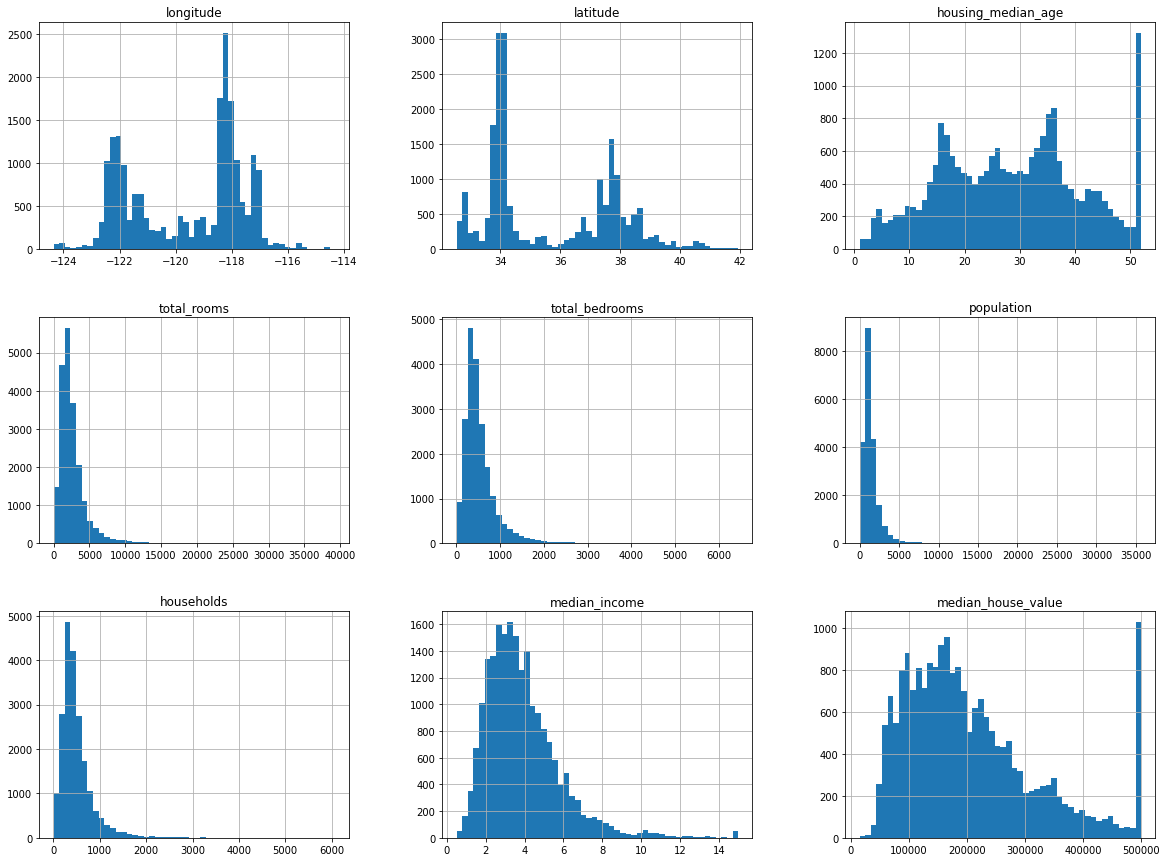

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

Notes to the summary of this first views:

Notable is that median_income is not in USD (preprocessed in this case), it's in 10 TUSD so 3 means about 30.000 USD. The Values are also capped between 0.5 and 15

housing_median_age is capped at 52

median_house_value is capped at $500.000. This could be a problem because its the target value. The algorithm could for example learn, that there is no home higher in value. 

<u>Solutions</u>: Talk to the team who needs to work with output and either:
- collect real labels for housing value
- remove dristricts with 500.000 value from dataset

### Further observations
- Attributes have very different scales, this will be discussed later on!
- Majority of histograms are <i>tail-heavy</i> (extend further to the right than to the left) --> Harder for some types of learning algorithms | Solution: Transformation to more bell-shaped distribution (e.g. by computing their logarithm)

### Info: Bell-shaped distripution allows to apply 68-95-99.7 rule (68% fall withoin 1sigma, 95% within 2 ...)

# Creating a Test Set

<u>Note:</u>
Here it's important to prevent <i>data snooping</i> bias by looking at the training data and detect first patterns that will lead to a certain decision when it comes to algorithm selection, resulting in an optimistic model!

### Test Sample Size

Size should normaly be 20% for smaller datasets and less for bigger dataset (e.g. 100.000.000 --> 1% = 100.000 test samples)

### Creating the training sample

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffeld_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffeld_indices[:test_set_size]
    train_indices = shuffeld_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


### Avoiding changing of the test set so the training alogrithm will be trained on the whole dataset

One Solution is to make a hash of an unique identifier of each instance and check which hash are test hashs

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set] # loc for lable based data ~ --> not in

In [12]:
# add index to housing dataset
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Problem here is that new data needs to be append to the end of the dataset and no row should be deleted
Other solution is to use most stable feature (e.g. longtitude / latitued):

In [13]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

print(len(train_set))
print(len(test_set))

16322
4318


In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Stratified Sampling

Normally random sampling is fine if dataset is big enough, but in some cases there could be the risk of sampling bias (e.g. if rato between males and females is not accurate). Therefore we need statified sampling to devide the population into homogeneous subgroups calles strata (pl.). One single group is called a stratum.

Here you can make sure each stratum has the right number of instances in it. <br>
<u>Note:</u> There should not bet to much strata and each stratum should big enough!

In [15]:
# In housing example, median incoume could be stratified in different categories
# Below pd.cut() will be used to create an "income category" with 5 categories (1-5)

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

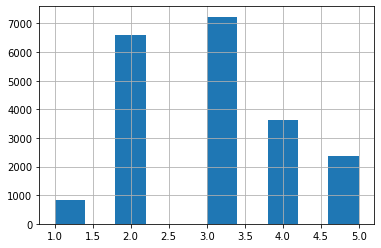

In [16]:
housing['income_cat'].hist()

Now its possible to do stratified sampling on the dataset. StratifiedShuffleSplit can be used for this

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To test if proportions are right in strat_test_set:

In [18]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

comparing to income proportions in full dataset

In [19]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

When done, always remove the added categorial attribute to bring dataset back to its original state

In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Exploring the Data
#### Discover and Visualize the Data to Gain Insights
<br>
<u>Note</u>: <br>
- Set traning set aside and only explore training data <br>
- Always create a copy of dataset for exploration. If dataset is very large, sampling an <b>exploration set</b> may be usefull.

In [21]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

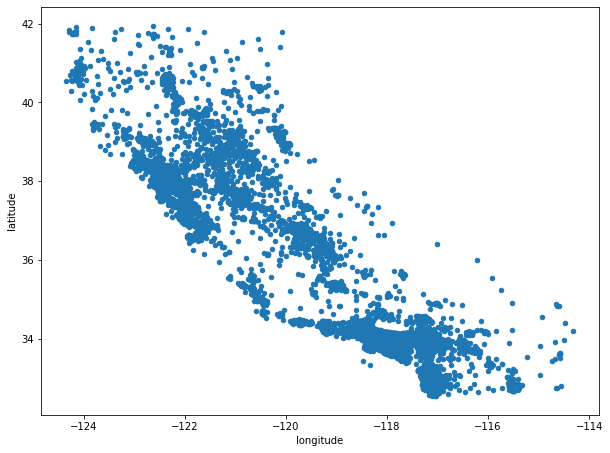

In [22]:
# should in general look like california

housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7.5))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

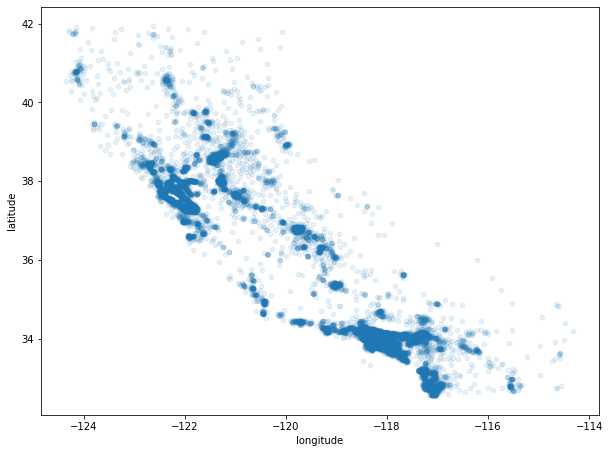

In [23]:
# setting alpha to 0.1 will show places where there is high density much easier
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7.5), alpha=0.1)

### Visualizing it togheter with price and district population

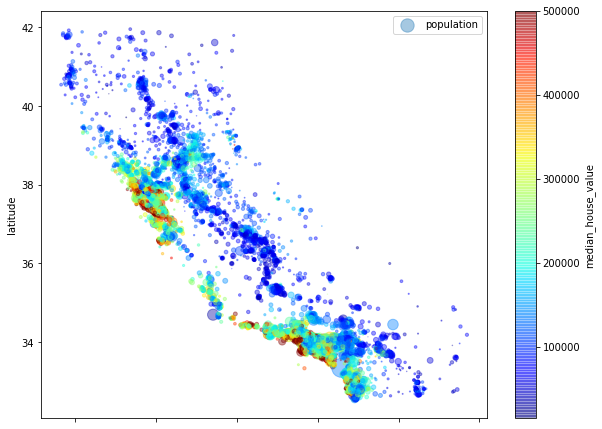

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7.5), alpha=0.4,
             s=housing['population']/100, label='population',
             c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True,
            )
plt.legend()

radius of each circle represents population (option s) <br>
color represents the price (median vaulue) (option c) <br>
for visualization, cmap jet is used to show colors of price from blue (low prices) to red (high prices)

Image shows, that housing prices are very much related to location and population (bay area)

<i>A Clustering Algorithm should be usefull for detecting main cluster. Also new feature could be added, that adds the proximity to cluster centers.</i> <br>
Maybe ocean proximity, but in this case nothern bay area has lower prices

### Looking for Correlations

Since dataset is not to large, Pearson's r correlation coef (standard correlation) can be be calculated between every pair of attributes

In [25]:
corr_matrix = housing.corr()

printing, how much each attributes correlates with median_house_value

In [26]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

<u>Note:</u> Correlation Coefficient only measures linear correlation between -1 and 1 (e.g. if x goes up, y goes up etc.)

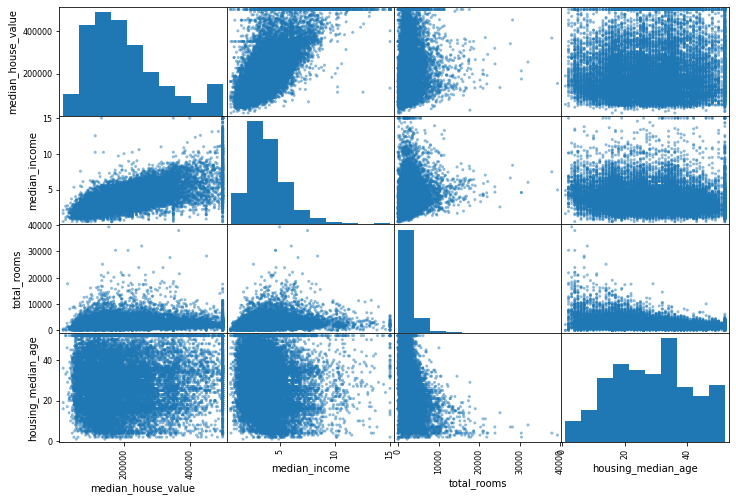

In [27]:
# Another way to check correlation visually is with pandas catter_matrix() 
#(compairs each numerical variable with all others) --> 11 Variables = 11^2 plots
# Set focus on promising ones!

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

<u>Note:</u> If attribute is plotted against itself (digonal top-left to bottom-right), pandas shows histogram instead of straight line

Since median_income is most promising attribute to predict median_house_value let's plot them togheter

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

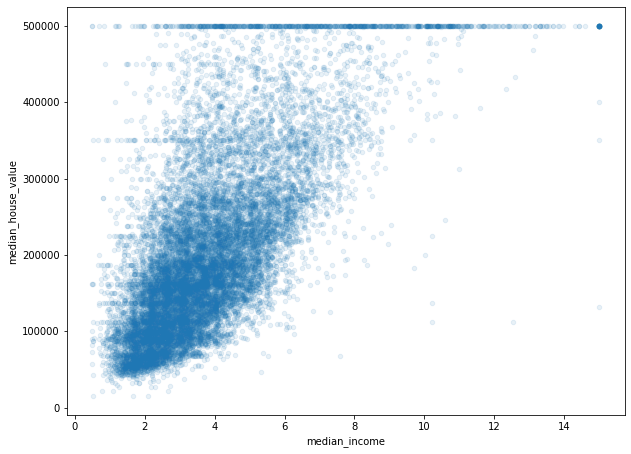

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=.1, figsize=(10,7.5))

Noteable:
- strong positiv correlation
- capped value at 500.000 by straight line
- other horizontal lines at 450.000, 350.000, 280.000 (->should might try removing corresponding districts to avoid your algorithm from picking up this patterns and reproducing this data quirks) 

### Experimenting with Attribute Combinations

Checking on multiple combination of certain attributes (e.g. number of bedrooms by itself not very useful, probably comparing it to the number of total rooms will help)

In this dataset, also population per houshold might be a interessting combination to look at

In [29]:
# creation of new attributes

housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

# feeding this back to the correlation matrix (Pearson's Coefficient) --> only linear correlation between -1 and 1

corr_matrix=housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Success --> the new bedrooms_per_room attribute correlates much stronger with median_house_value than total_bedrooms or total_rooms! <br>
rooms_per_household also correlates stronger then the single attributes
Outcome: houses with a lower bedroom/room ratio tend to be more expensive, houses with more rooms per household (bigger houses) are more expensive

<i><u>Rememberg:</u> Machine Learning is an iterative process, one starts with an exploration to quickly gain insights, then after building the first prototype one comes back to analyse the ouput end for further data exploration.</i>

## Prepate the Data for Machine Learning Algorithms

_NOTE:_ Don't do this manually, alwayse write functions because:
- easy reproduction of transformations on any dataset
- gradualy build own library of function to use in later projects
- function can be used in live system to prepare new data before feeding it to algorithm (e.g. online learning)
- possibility to change functions on the fly and find best combinations

In [30]:
# reset of housing data
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

As seen with <code>.info()</code> total_bedrooms has some missing values. Most learning algorithms can't work with missing features. There are in general three Options:

In [31]:
#housing.dropna(subset=['total_bedrooms'])   # option 1: drop corresponding districts(rows)
#housing.drop('total_bedrooms', axis = 1)    # option 2: drop whole attribute

#median = housing['total_bedrooms'].median() # option 3: fill missing values (e.g. median)
#housing['total_bedrooms'].fillna(median, inplace=True)

# Note: median should be saved securly to use it on test data and production system!

In [32]:
# working with Imputer from sklearn:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# since imputing median only works on numerical attributes:
housing_num = housing.drop('ocean_proximity', axis=1)

# fitting the imputer
imputer.fit(housing_num)

# .statistics_ shows all the computed medians for every numerical attribute
print(imputer.statistics_)
print(housing_num.median().values) # for comparison

# Note: It's always save to apply imputer to all numerical values in case they are missing in production system!

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


Now we can use "trained" imputer to transform the training_set

In [33]:
X = imputer.transform(housing_num) # result will be a numpy array
housing_transformed = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # puttung it back into pandas DataFrame

In [34]:
## Page 64-65 Learn more about Scikit-Learn Design of features!

### Handling Text and Categorical Attributes

In this dataset only one categorical attribute = <code>"ocean_proximity"</code>

In [35]:
housing_cat = housing[['ocean_proximity']] # --> transformed to numpy array
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


_Notable:_ No arbitrary text. It consists out of different categories. --> Categorical attribute

These are ordinal variables, cause they have a specific order. These can be easily encoded to numbers (works with most learning algorithms)

In [36]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # optimazied combination of fitting and transforming
housing_cat_encoded[:10] # show first 10 entries

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [37]:
# getting list of categories 
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Problem: OrdinalEncoder doesn't find the simalarites between those categories (e.g. 0 and 4 are more similar than 0 and 1). Tho solve this, OneHotEncoder can be used to set binary attributes per attribute (1 for attribute, 0 if not) --> creates one new column for each category, so its recommended only using this method for low cardinality attributes (e.g. < 10). <br>
<br>
For high cardinality attributes might consider to exchange category with numerical value (e.g. distance in km to ocean)
<br>
If not possible you could alternatively replace each category with  learnable, low-dimensional vector called an ___embedding___ --> each categories representation will be learned (representation learning)

In [38]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [39]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

Creating custom transformer class to add custom operations

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
# BaseEstimator adds get_params(), set_params
# TransformerMixin adds fit_transform()

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): # class to combine attributes (from earlier, e.g. rooms_per_household)
    
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs!
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    

In [41]:
# class helps to determine if adding attribute "bedrooms_per_room" will help or not

# add_bedrooms_per_room ==> hyperparamter
# The more hyperparamters the more combinations you can automaticaly test --> more likely to find great combi!

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

One of the most important transformation / preprocessing step <b>because most m-learning algorithms don't perform very well when the input numerical values have very different scales</b>

<br>
Note: Scaling the target values is generally not required!

<br>

__IMPORTANT__: As with all transformation steps it's important to only fit them to the training data (exluding test data)

In [42]:
# min-max-scaling: (normalization) rescales values between 0 to 1 | -min / (max-min) (strongl affected by outliers)
# standardization: subtracts mean --> zero mean, and then divides by standard deviation (less affected by outliers)
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Transformation Pipelines

Pipelines are for combining / organizing transformation steps. Pipelines take a list of name / estimator pairs that are combined to a sequence of steps. Calls fit_transform method sequentially on input data. First transforming all then <code>.fit()</code> on output
<br>
The names can be anything as long as they are unique and whithout double underscores '__'.

__NOTE:__ All the estimators must be transformers that have .fit_transform() method!

In [43]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()) 
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [44]:
from sklearn.compose import ColumnTransformer # handles numerical and categorical data in one place

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

__Note:__ 
- transformers must output same number of rows than input data --> writing small test
- If output is mixed between dense and sparse matrice, ColumnTransformer returns a sparse matrice if density is lower than a given threshold (default = 0.3)
- by default all remaining columns (not listed) will be dropped, change hyperparameter <code>remainder = "passthrough"</code> to leave them untouched)

## Select and Train a Model

### Training and Evaluating on the Training Set

In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [46]:
# tesing

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predicitons:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predicitons: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


__Measuring the RMSE__ on the whole training set

In [47]:
from sklearn.metrics import mean_squared_error

housing_predicitions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predicitions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Not a great score --> typical prediction error of 68.628 USD. ---> Example of __UNDERFITTING__ <br><br>
<u>It could mean:</u>
- that the features don't provide enough information to make good predictions
- that the model is not powerfull enough

<br>

<u>Possible Solutions:</u>
- selecting a more powerfull model
- feed training algorithm with better features
- reduce constraints on model (only for regularized models --> here not the case)

#### Using a more powerfull model

Decision Tree for example is a powerfull model thats capable of finding complex nonlinear relationships

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predicitions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predicitions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

No error at all (--> possible __OVERFITTING__ the training data)

### Better Evaluation Using Cross-Validation 

Separating the training data into a specific number of "folds" (K-fold cross-validation). Training 10 different models each with another validation set and fitting the remaining 9 folds as training data to the model. --> 10 Iterations

<br>

<u>Advantages:</u>
- good estimation of accuracy
- also tells how precice estimation is (std deviation)

<u>Disadvantages:</u>
- not always possible because model needs to be trained several times (good for small datasets)

<br>

__Note:__ cross-validation expects utility (greater = better) function and not a cost function (lower = better). This is why negative mean_squared_error is used

In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [67919.61640889 66851.27771317 70387.85615633 68756.07862017
 70884.10338759 74839.29408642 71582.21374456 72991.16158536
 77120.55672346 70624.89466457]
Mean: 71195.70530905187
Standard deviation 2972.9914946703975


Approximated error of 70309 USD, generally +/- 2911 USD

<br>

__Note:__ cross-validation gives not only a estimation of the performance but also how precise this estimation ist (e.g. its standard deviation) 

Same for the Linear Model to check back

In [50]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation 2731.674001798344


Decision Tree overfits so bad, it performes worse than linear regression

Trying on more model
#### RandomForestRegressor
Consists out of many DecisionTrees --> Model build ontop of many other models --> "Ensemble Learning"!

In [51]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Score on Training Set:", forest_rmse)

Score on Training Set: 18661.87258051228


In [54]:
# HEAVY --> uncomment if needed!

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [49434.05472377 47317.33262832 49817.91972514 52042.99465307
 49781.18250712 53331.33856196 48737.61001617 47698.3347004
 53327.57881418 50282.00324981]
Mean: 50177.03495799404
Standard deviation 2014.9407144615911


##### Note: Always save models with hyperparameters, trained parameter, (cross-validation) scores and perhabs also the predicted values. This is good practice to have a possibility to always come back to certain models!

#### You can save models by using <code>pickle</code> or <code>joblib</code> (joblib is more efficient for serializing large numpy arrays)

In [53]:
#import joblib

#joblib.dump(forest_reg, "saved_models/forest_reg_housing_cf.pkl")

# to load model:
#forest_reg_loaded = joblib.load("forest_reg_housing_cf.pkl")

## Fine-Tune the Model

### Grid Search

Manually fiddle with the hyperparameters is one option but very time consuming and obviously not recommended. Grid Search helps with that and searches the optimal parameters automatically

For example GridSearch for RandomForest --> tries all possible combinations of parameters and uses cross-validation to validate them.

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, # cv=5 5 folds for cross-validation
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The grid search above tests 3 x 4 = 12 combinations of hyperparameters in first dict, then 2 x 3 = 6 combinations in the second dicts with <code>bootstrap = False</code>. Each model will be trained 5 times on hyperparamter combination because <code>cv=5</code> (5 Folds) by cross-validation

In [57]:
# to get the best paramters from the grid search:

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

Since the best params are both max values, futher training would be recommended

In [60]:
grid_search.best_estimator_ # getting the best estimators directly

RandomForestRegressor(max_features=6, n_estimators=30)

Getting all the evluation cores from cross-validation:

In [61]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63866.34339574576 {'max_features': 2, 'n_estimators': 3}
55378.271044134686 {'max_features': 2, 'n_estimators': 10}
53004.51334784968 {'max_features': 2, 'n_estimators': 30}
60562.48163966558 {'max_features': 4, 'n_estimators': 3}
52909.35731056397 {'max_features': 4, 'n_estimators': 10}
50363.68421901991 {'max_features': 4, 'n_estimators': 30}
59058.57829698436 {'max_features': 6, 'n_estimators': 3}
51908.35754585722 {'max_features': 6, 'n_estimators': 10}
50016.6295975855 {'max_features': 6, 'n_estimators': 30}
59156.57088370758 {'max_features': 8, 'n_estimators': 3}
52172.05300902692 {'max_features': 8, 'n_estimators': 10}
50198.009240130916 {'max_features': 8, 'n_estimators': 30}
62062.853507098705 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54427.78453311949 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60951.15652778402 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52503.86299207883 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

Successfully fine tuned, cause score is little better then with the default hyperparameters

### Randomized Search

If there are only a few hyperparamters, Grid Search is fine, if the hyperparamter space is bigger, Randomized Search is recommended

In [63]:
#from sklearn.model_selection import RandomizedSearchCV

#RandomizedSearchCV?

### Ensemble Methods

Another way of finetuning is to combine models that perfom the best (e.g. RandomForest vs. single DecisionTree).

### Analyze the Best Models and Their Errors

In [66]:
# looking at the relative importance of each attribute for making predictions

feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([7.54307917e-02, 6.51742847e-02, 4.45235756e-02, 1.99451145e-02,
       1.68825013e-02, 1.73373030e-02, 1.64356542e-02, 3.17319613e-01,
       5.65249804e-02, 1.08379697e-01, 8.87564535e-02, 1.19206231e-02,
       1.54161620e-01, 7.96213882e-05, 3.09917479e-03, 4.02899185e-03])

In [70]:
# display importance scores next to corresponding attribute name

extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat'] # extracts pipeline step with "cat"
cat_one_hot_attribs = list(cat_encoder.categories_[0]) # get the cateogrie names from OneHotEncoder
attributes = num_attribs + extra_attribs + cat_one_hot_attribs # concat all attribute names
sorted(zip(feature_importance, attributes), reverse=True)

[(0.31731961260635827, 'median_income'),
 (0.1541616203913657, 'INLAND'),
 (0.10837969691139908, 'population_per_household'),
 (0.08875645351575734, 'bedrooms_per_room'),
 (0.07543079171494181, 'longitude'),
 (0.06517428473711298, 'latitude'),
 (0.05652498038297515, 'rooms_per_household'),
 (0.0445235756281003, 'housing_median_age'),
 (0.019945114507405732, 'total_rooms'),
 (0.01733730299875442, 'population'),
 (0.016882501349439832, 'total_bedrooms'),
 (0.016435654182333722, 'households'),
 (0.011920623053806666, '<1H OCEAN'),
 (0.004028991845620581, 'NEAR OCEAN'),
 (0.003099174786436799, 'NEAR BAY'),
 (7.962138819182362e-05, 'ISLAND')]

This helps to understand why model makes specific errors or indication of adding new features and dropping uninformative ones (e.g. only one category of "ocean_proximity" is apprently usefull in this case 

### Evaluate System on the Test Set

In [72]:
final_model = grid_search.best_estimator_ # outputs the model with best estimators from grid search

# this is the first time touching the testset again

X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test) # transfrom the test data (DON'T USE fit_transform()!)

final_predictions = final_model.predict(X_test_prepared)

final_mse =  mean_squared_error(final_predictions, y_test)
final_rmse = np.sqrt(final_mse)

final_rmse

48183.161767125006

To get an idea of how precise this estimate is, a 95% confidence intervall can be computed using scypi

In [73]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(), # default = 0 sets middle of intervall
                         scale=stats.sem(squared_errors)))

array([46231.47898575, 50058.81047872])

with 95% certainty the root mean squared error is located between 46,231.00 USD and 50,059.00 USD